In [1]:
#Importing the necessary libraries
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from sklearn.linear_model import LinearRegression, Ridge,SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_absolute_error,r2_score
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

In [2]:
#reading the data

train_data = pd.read_csv(r'C:\Users\fifok\Downloads\train_data.csv')

#### Proceed to cleaning the data

- CHeck for High and Low cardinality
- Check for columns with >50% null cells
- Check for Leakages
- Check for Multicollinearity
- Check for outliers

In [3]:
#preview the data

train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# This is the function that automatically wrangles the data

def wrangle(path):
    
    #read in the data into a dataframe
    df = pd.read_csv(path)
    
    #Removing the columns with too many Null values
    null_cols = ['Alley','FireplaceQu','PoolQC','MiscFeature','Fence']
    df.drop(columns = null_cols, inplace = True)
    
    #Remove features that would constitute leakage
    leak_cols = ['MiscVal','SaleType','SaleCondition']
    df.drop(columns = leak_cols, inplace = True)
    
    #remove a column that cannot be reproduced in real time
    df.drop(columns = 'YrSold', inplace = True)
    
    #remove overallcond and overall quality of the house, because it sort of tell the model how to value the house
    df.drop(columns = ['OverallQual','OverallCond'], inplace = True)
    
    #remove year built and year RemoAdd
    df.drop(columns = ['YearBuilt','YearRemodAdd'], inplace = True)
    
    #MSsubclass is a categorical variable and not a numerical variable, convert to categorical
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    
    #removing features with low predictive power - less correlation with the target

    less_target_cols = ['BsmtFinSF1','BsmtFinType2','BsmtFinSF2','LowQualFinSF','BsmtFullBath','BsmtHalfBath','HalfBath',
                   'KitchenAbvGr','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MoSold','GarageCars','1stFlrSF','TotRmsAbvGrd',
                       'LotFrontage','LotArea','BsmtUnfSF','2ndFlrSF','GarageYrBlt','WoodDeckSF','OpenPorchSF','BedroomAbvGr','MasVnrArea']
    
    df.drop(columns = less_target_cols,inplace=True)
    
    # Removing High and Low Cardinality categorical variables in the dataset
    low_cal_cols = ['Street','Utilities','CentralAir']
    
    #drop columns
    df.drop(columns = low_cal_cols,inplace=True)    
    
    #removing the categorical columns that have low predicting power
    cat_low_pred = ['MSZoning','LandContour','Condition1','Condition2','RoofStyle','RoofMatl','MasVnrType',
               'ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','Heating','Electrical',
               'KitchenQual','Functional','GarageQual','GarageCond','PavedDrive','LotConfig','GarageFinish','Exterior1st']
    
    df.drop(columns =cat_low_pred, inplace =True)
    
    #remove Outlier
    low, high = df['SalePrice'].quantile([0.05,0.95])
    mask = df['SalePrice'].between(low,high)
    
    df = df[mask]
    
    return df

In [5]:
data = wrangle(r'C:\Users\fifok\Downloads\train_data.csv')

In [6]:
#correlation of the numerical variables
cor = data.select_dtypes("number").corr()
cor

,TotalBsmtSF,GrLivArea,FullBath,Fireplaces,GarageArea,SalePrice
TotalBsmtSF,1.000000,0.352027,0.255812,0.247306,0.418548,0.502273
GrLivArea,0.352027,1.000000,0.587327,0.390679,0.375407,0.621693
FullBath,0.255812,0.587327,1.000000,0.182739,0.355231,0.555348
Fireplaces,0.247306,0.390679,0.182739,1.000000,0.183644,0.416494
GarageArea,0.418548,0.375407,0.355231,0.183644,1.000000,0.577847
SalePrice,0.502273,0.621693,0.555348,0.416494,0.577847,1.000000


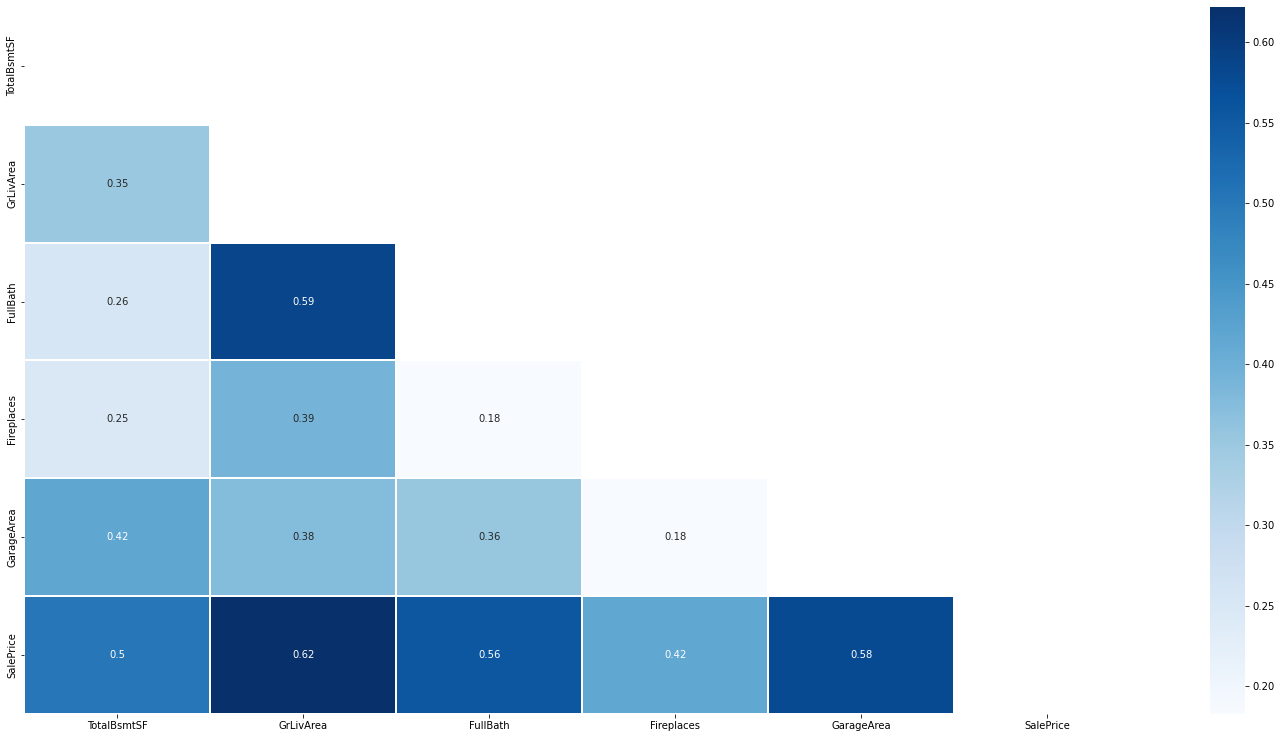

In [7]:
#correlation plot
plt.figure(figsize=(25,13))
mask = np.triu(np.ones_like(cor, dtype=bool))

sns.heatmap(cor, mask = mask ,linewidth = 2, annot=True,  cmap = "Blues");

In [8]:
#DataFrame with just the categorical variables
cat_data = data.select_dtypes("object")

In [9]:
cat_data

,MSSubClass,LotShape,LandSlope,Neighborhood,BldgType,HouseStyle,Exterior2nd,BsmtFinType1,HeatingQC,GarageType
0,60,Reg,Gtl,CollgCr,1Fam,2Story,VinylSd,GLQ,Ex,Attchd
1,20,Reg,Gtl,Veenker,1Fam,1Story,MetalSd,ALQ,Ex,Attchd
2,60,IR1,Gtl,CollgCr,1Fam,2Story,VinylSd,GLQ,Ex,Attchd
3,70,IR1,Gtl,Crawfor,1Fam,2Story,Wd Shng,ALQ,Gd,Detchd
4,60,IR1,Gtl,NoRidge,1Fam,2Story,VinylSd,GLQ,Ex,Attchd
...,...,...,...,...,...,...,...,...,...,...
1309,20,Reg,Gtl,Somerst,1Fam,1Story,VinylSd,GLQ,Ex,Attchd
1310,60,Reg,Gtl,Gilbert,1Fam,2Story,VinylSd,Unf,Ex,Attchd
1311,20,Reg,Gtl,NWAmes,1Fam,1Story,Plywood,ALQ,TA,Attchd
1312,70,Reg,Gtl,Crawfor,1Fam,2Story,CmentBd,GLQ,Ex,Attchd


In [10]:
cat_df =[]

In [11]:
cat_data

,MSSubClass,LotShape,LandSlope,Neighborhood,BldgType,HouseStyle,Exterior2nd,BsmtFinType1,HeatingQC,GarageType
0,60,Reg,Gtl,CollgCr,1Fam,2Story,VinylSd,GLQ,Ex,Attchd
1,20,Reg,Gtl,Veenker,1Fam,1Story,MetalSd,ALQ,Ex,Attchd
2,60,IR1,Gtl,CollgCr,1Fam,2Story,VinylSd,GLQ,Ex,Attchd
3,70,IR1,Gtl,Crawfor,1Fam,2Story,Wd Shng,ALQ,Gd,Detchd
4,60,IR1,Gtl,NoRidge,1Fam,2Story,VinylSd,GLQ,Ex,Attchd
...,...,...,...,...,...,...,...,...,...,...
1309,20,Reg,Gtl,Somerst,1Fam,1Story,VinylSd,GLQ,Ex,Attchd
1310,60,Reg,Gtl,Gilbert,1Fam,2Story,VinylSd,Unf,Ex,Attchd
1311,20,Reg,Gtl,NWAmes,1Fam,1Story,Plywood,ALQ,TA,Attchd
1312,70,Reg,Gtl,Crawfor,1Fam,2Story,CmentBd,GLQ,Ex,Attchd


In [12]:
#using label encoder to replace the categorical values with numerical variables

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
for d in cat_data:
    cat_data[d] = label.fit_transform(cat_data[d])

In [13]:
cat_data

,MSSubClass,LotShape,LandSlope,Neighborhood,BldgType,HouseStyle,Exterior2nd,BsmtFinType1,HeatingQC,GarageType
0,9,3,0,5,0,5,13,2,0,1
1,4,3,0,24,0,2,8,0,0,1
2,9,0,0,5,0,5,13,2,0,1
3,10,0,0,6,0,5,15,0,2,5
4,9,0,0,15,0,5,13,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1309,4,3,0,21,0,2,13,2,0,1
1310,9,3,0,8,0,5,13,5,0,1
1311,4,3,0,14,0,2,10,0,3,1
1312,10,3,0,6,0,5,5,2,0,1


In [14]:
#trimming out sales vector for feature selection on categorical variable using Chi Square
sales = data['SalePrice']

In [15]:
#check for multicollinearity in the categorical data

cat_cor = cat_data.corr()

In [16]:
#view the categorical data
cat_data

,MSSubClass,LotShape,LandSlope,Neighborhood,BldgType,HouseStyle,Exterior2nd,BsmtFinType1,HeatingQC,GarageType
0,9,3,0,5,0,5,13,2,0,1
1,4,3,0,24,0,2,8,0,0,1
2,9,0,0,5,0,5,13,2,0,1
3,10,0,0,6,0,5,15,0,2,5
4,9,0,0,15,0,5,13,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1309,4,3,0,21,0,2,13,2,0,1
1310,9,3,0,8,0,5,13,5,0,1
1311,4,3,0,14,0,2,10,0,3,1
1312,10,3,0,6,0,5,5,2,0,1


In [17]:
#Running the Chi Square Analysis
f_p_values = chi2(cat_data,sales)

In [18]:
mask = (np.triu(np.ones_like(cat_cor)));

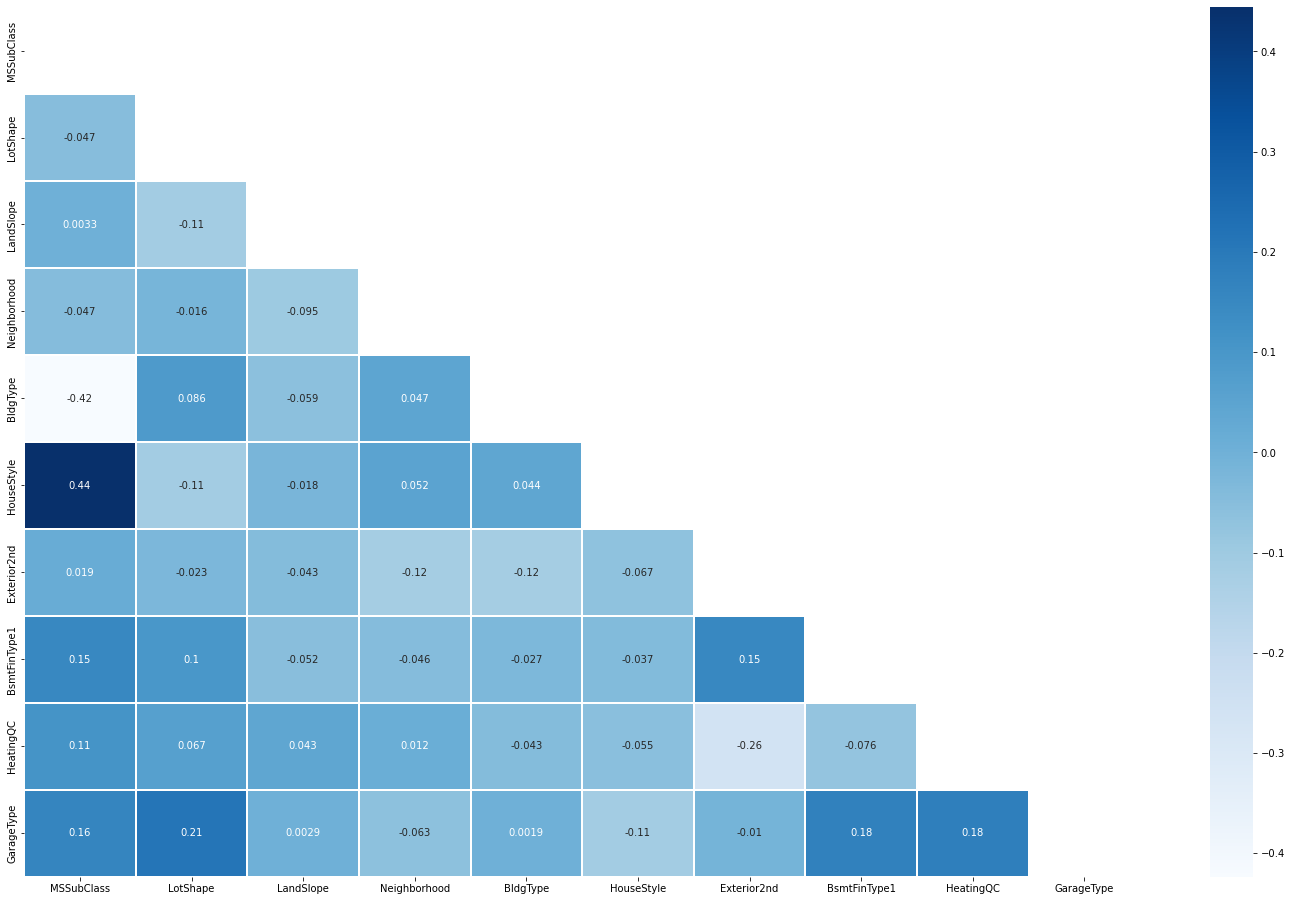

In [19]:
plt.figure(figsize=(25,16))
sns.heatmap(cat_cor
            , mask=mask,
           linewidths=2,
           annot = True,
           cmap = 'Blues');

In [20]:
#Select P values of co-efficients 
p =f_p_values[1]

In [21]:
#Create a series for the chi square test
chi_square_test = pd.Series(p, index = cat_data.columns)

###### Please note that the categorical variables with probability values greater than 0.05 have been expunged from the Wrangle function above

In [22]:
chi_square_test

MSSubClass       7.786802e-35
LotShape         3.986934e-04
LandSlope        3.291473e-02
Neighborhood    2.913652e-126
BldgType        2.127813e-103
HouseStyle       1.864553e-05
Exterior2nd      1.440435e-02
BsmtFinType1     2.714825e-05
HeatingQC        1.092110e-17
GarageType       3.456014e-27
dtype: float64

### Data Exploration

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1182 entries, 0 to 1313
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MSSubClass    1182 non-null   object
 1   LotShape      1182 non-null   object
 2   LandSlope     1182 non-null   object
 3   Neighborhood  1182 non-null   object
 4   BldgType      1182 non-null   object
 5   HouseStyle    1182 non-null   object
 6   Exterior2nd   1182 non-null   object
 7   BsmtFinType1  1157 non-null   object
 8   TotalBsmtSF   1182 non-null   int64 
 9   HeatingQC     1182 non-null   object
 10  GrLivArea     1182 non-null   int64 
 11  FullBath      1182 non-null   int64 
 12  Fireplaces    1182 non-null   int64 
 13  GarageType    1135 non-null   object
 14  GarageArea    1182 non-null   int64 
 15  SalePrice     1182 non-null   int64 
dtypes: int64(6), object(10)
memory usage: 157.0+ KB


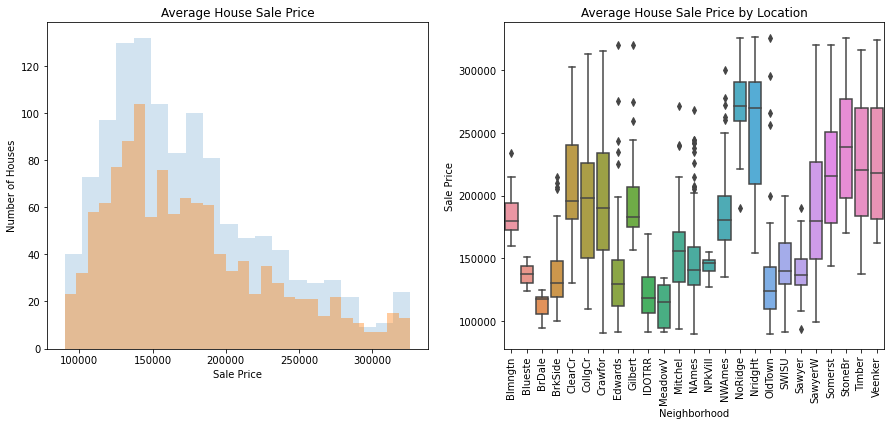

In [24]:
plt.figure(figsize = [15,6])


plt.subplot(1,2,1)
plt.hist(data = data, x = 'SalePrice', bins = 20, alpha = 0.2);
plt.hist(data = data, x = 'SalePrice', bins = 30, alpha = 0.4);
plt.title("Average House Sale Price")
plt.xlabel('Sale Price');
plt.ylabel("Number of Houses")

plt.subplot(1,2,2)
neighbourhood_order = data['Neighborhood'].value_counts().sort_index().index
sns.boxplot(data = data,x='Neighborhood',y='SalePrice',order = neighbourhood_order)
plt.title("Average House Sale Price by Location")
plt.xlabel('Neighborhood');
plt.ylabel("Sale Price")
plt.xticks(rotation = 90);


- The average sale price is  ~ $160,000
- Houses in the NWAmes, NoRidge neighborhoods are more expensive on an average.

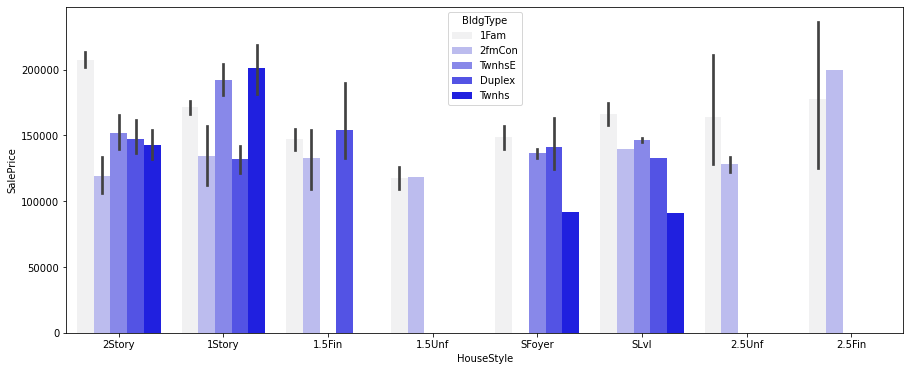

In [25]:
plt.figure(figsize = (15,6))
sns.barplot(data = data, x='HouseStyle',y='SalePrice',hue='BldgType', color = 'blue');

In [26]:
Bldg = round(pd.DataFrame(data.groupby(['HouseStyle','BldgType'])['SalePrice'].mean()),0)
Bldg =Bldg.sort_values(by ='SalePrice',ascending=False)

<Figure size 1080x432 with 0 Axes>

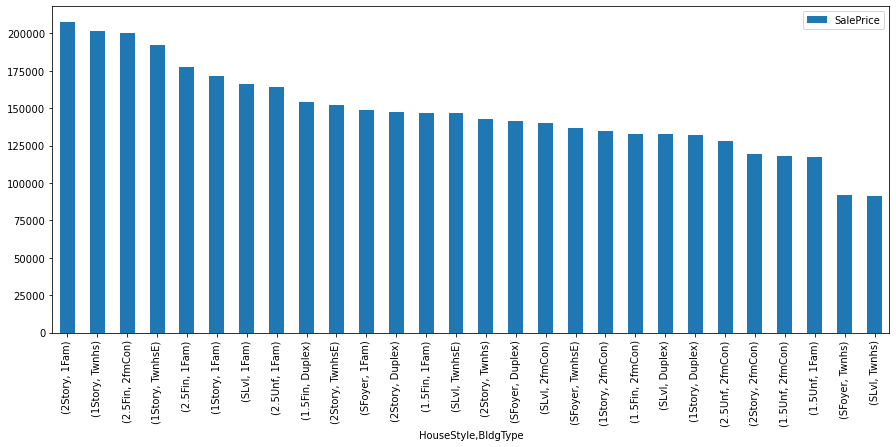

In [27]:
plt.figure(figsize = [15,6]);
Bldg.plot(kind='bar',figsize=(15,6));

- The Building Type or House Type is not a strong factor that affects the price of the house, Location of the house takes precendence with pricing the house.

#### DATA MODELLING

In [28]:
#Split data into target vector and feature matrix
y_target = data['SalePrice']
X_features = data.drop(columns='SalePrice')

In [29]:
#Spliting the data into train and test data

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42)

print("X_train: {}".format(X_train.shape))
print("X_test: {}".format(X_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))

X_train: (945, 15)
X_test: (237, 15)
y_train: (945,)
y_test: (237,)


#### Create baseline model

In [30]:
#creating the baseline model for the dataset and calculate the baseline mean absolute error

y_pred_baseline = [y_train.mean()] * len(y_train)

#calculate the baseline mae
baseline = mean_absolute_error(y_train,y_pred_baseline)
baseline = baseline.round(2)
print(f"The baseline MAE: {baseline}")

The baseline MAE: 43305.41


In [31]:
#create a dict of linear regression models and pick the best model

models = {
    "Linear Regression":LinearRegression(),
    "Ridge":Ridge(),
    "Gradient Descent":SGDRegressor(max_iter=5),
    "Gradient Boosting":GradientBoostingRegressor(),
    "XGboost":XGBRegressor()
    
}

In [32]:
#create a loop that picks each of the models and run inside a pipeline
list_model = []

for i in range(len(list(models))):
    model_iterate = list(models.values())[i]
    model_name = list(models.keys())[i]
    model = make_pipeline(
        OneHotEncoder(handle_unknown = 'ignore'),
        SimpleImputer(),
        model_iterate        
    )
    model.fit(X_train,y_train)
    model_mae = round(mean_absolute_error(y_train, model.predict(X_train)),2)
    model_score =round(r2_score(y_train, model.predict(X_train)),2)
    #print(f'The Training MAE of the {model_iterate} model is:{model_mae}')
    #print(f'The Training R Squared of the {model_iterate} model is:{model_score}')
    
    #print("-------------------------------------------------------------------")
    
    model_test_mae = round(mean_absolute_error(y_test, model.predict(X_test)),2)
    model_test_score =round(r2_score(y_test, model.predict(X_test)),2)
    
    
    #print(f'The Test MAE of the {model_iterate} model is:{model_test_mae}')
    #print(f'The Test R Squared of the {model_iterate} model is:{model_test_score}')
    
    #print("===================================================================")
    
    details = {
        
        'Model Name':model_name,
        'Model Training MAE':model_mae,
        'Model Training Score':model_score,
        'Model Test MAE':model_test_mae,
        'Model Test Score':model_test_score
    }
    
    list_model.append(details)
    
#create a dataframe that shows the training and test MAE and scores for the algorithms
evaluation_df = pd.DataFrame(list_model).set_index('Model Name')
    
evaluation_df
  



,Model Training MAE,Model Training Score,Model Test MAE,Model Test Score
Model Name,,,,
Linear Regression,48.54,1.00,40995.58,0.13
Ridge,7386.70,0.97,21907.42,0.72
Gradient Descent,24784.00,0.62,26780.93,0.59
Gradient Boosting,19024.10,0.80,23371.86,0.67
XGboost,10137.92,0.95,23029.18,0.70


The **RIDGE** Regression Model is the most efficient with the least Mean Absolute Error and a R Squared of 97% and test MAE and Score of 21729 and 73% respectively......

In [33]:
#create a pipleine for the Ridge Model
Ridge_model = make_pipeline(
        OneHotEncoder(handle_unknown = 'ignore'),
        SimpleImputer(),
        Ridge()        
    )
Ridge_model.fit(X_train,y_train) 

Pipeline(steps=[('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

### Communicate Results

In [36]:
#create a function that would accept the inputs

def make_prediction(MSSubClass, LotShape, LandSlope, Neighborhood, BldgType,HouseStyle, Exterior2nd, BsmtFinType1,
       TotalBsmtSF, HeatingQC, GrLivArea, FullBath, Fireplaces,GarageType, GarageArea):
    
    data_inputs ={
        'MSSubClass' : MSSubClass,
        'LotShape' : LotShape,
        'LandSlope' : LandSlope,
        'Neighborhood' : Neighborhood,
        'BldgType' : BldgType,
        'HouseStyle' : HouseStyle,
        'Exterior2nd' : Exterior2nd,
        'BsmtFinType1' : BsmtFinType1,
        'TotalBsmtSF' : TotalBsmtSF,
        'HeatingQC' : HeatingQC,
        'GrLivArea' : GrLivArea,
        'FullBath' : FullBath,
        'Fireplaces' : Fireplaces,
        'GarageType' : GarageType,
        'GarageArea' : GarageArea  
    }
    
    df = pd.DataFrame(data_inputs, index=[0])
    prediction = Ridge_model.predict(df).round(2)[0]
    return f"Predicted House Price: ${prediction}"

In [37]:
#using the IPwidgets to communicate results
interact(
    make_prediction,
    TotalBsmtSF=IntSlider(
        min=X_features["TotalBsmtSF"].min(),
        max=X_features["TotalBsmtSF"].max(),
        value=X_features["TotalBsmtSF"].mean(),
    ),
    
    GrLivArea=IntSlider(
        min=X_features["GrLivArea"].min(),
        max=X_features["GrLivArea"].max(),
        value=X_features["GrLivArea"].mean(),
    ),
    FullBath=IntSlider(
        min=X_features["FullBath"].min(),
        max=X_features["FullBath"].max(),
        value=X_features["FullBath"].mean(),
    ),
    Fireplaces=IntSlider(
        min=X_features["Fireplaces"].min(),
        max=X_features["Fireplaces"].max(),
        value=X_features["Fireplaces"].mean(),
    ),
    GarageArea=IntSlider(
        min=X_features["GarageArea"].min(),
        max=X_features["GarageArea"].max(),
        value=X_features["GarageArea"].mean(),
    ),
    
    Neighborhood=Dropdown(options=sorted(X_features["Neighborhood"].unique())),
    MSSubClass=Dropdown(options=sorted(X_features["MSSubClass"].unique())),
    LotShape=Dropdown(options=sorted(X_features["LotShape"].unique())),
    LandSlope=Dropdown(options=sorted(X_features["LandSlope"].unique())),
    BldgType=Dropdown(options=sorted(X_features["BldgType"].unique())),
    HouseStyle=Dropdown(options=sorted(X_features["HouseStyle"].unique())),
    Exterior2nd=Dropdown(options=sorted(X_features["Exterior2nd"].unique())),
    HeatingQC=Dropdown(options=sorted(X_features["HeatingQC"].unique())),
    BsmtFinType1=Dropdown(options=sorted(X_features["BsmtFinType1"].dropna().unique())),
    GarageType=Dropdown(options=sorted(X_features["GarageType"].dropna().unique())),

);

interactive(children=(Dropdown(description='MSSubClass', options=('120', '160', '180', '190', '20', '30', '40'…